<a href="https://colab.research.google.com/github/johan-stph/thesis/blob/main/heatmap_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
!tar -xvf images.tar


In [4]:
import torch
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2
from torchvision.models.vgg import VGG16_Weights

# Global variable to store activations
activations = None

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

100%|██████████| 170498071/170498071 [00:14<00:00, 11639364.91it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
def load_model():
    # Step 2: Load the pre-trained VGG16 model
    model = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
    model.eval()


    model = model.to(device)

    # Enable gradients for the parameters
    for param in model.parameters():
        param.requires_grad = True

    return model

def load_data():
    # Step 3: Load the dataset
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    dataset = ImageFolder('Images', transform=preprocess)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=5, shuffle=True)

    return dataloader

def forward_hook(module, input, output):
    global activations
    activations = output

def register_hook(model):
    # Step 5: Register a forward hook on the last convolutional layer
    model.features[-3].register_forward_hook(forward_hook)

def forward_pass(model, image):
    # Step 6: Forward pass and get the output
    if torch.cuda.is_available():
        image = image.to(device)

    output = model(image)

    _, predicted_class = torch.max(output, 1)
    model.zero_grad()
    output[0, predicted_class].backward()

    return output, predicted_class

def compute_gradients(model):
    gradients = model.features[-3].weight.grad
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    for j in range(512):
        activations[:, j, :, :] *= pooled_gradients[j]

    return activations

def generate_heatmap(activations):
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = np.maximum(heatmap.detach().cpu().numpy(), 0)
    heatmap /= np.max(heatmap)

    return heatmap

def display_images(image, heatmap):
    # display the original image and the heatmap
    plt.figure(figsize=(10, 4))

    # original image
    plt.subplot(1, 3, 1)
    img = image.cpu().numpy()
    if img.ndim == 3:  # add batch dimension if not present
      img = np.expand_dims(img, axis=0)
    img = img.transpose((0, 2, 3, 1))  # now we're sure there's a batch dimension
    img = img[0]  # remove the batch dimension for display
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # unnormalize
    img = img.clip(0, 1)
    plt.imshow(img)
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap, cmap='jet')
    plt.title('Heatmap')

    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    plt.subplot(1, 3, 3)
    plt.imshow(img)
    plt.imshow(heatmap_resized, cmap='jet', alpha=0.5, interpolation='none')  # overlay with transparency
    plt.title('Overlay')
    plt.show()



Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 295MB/s]


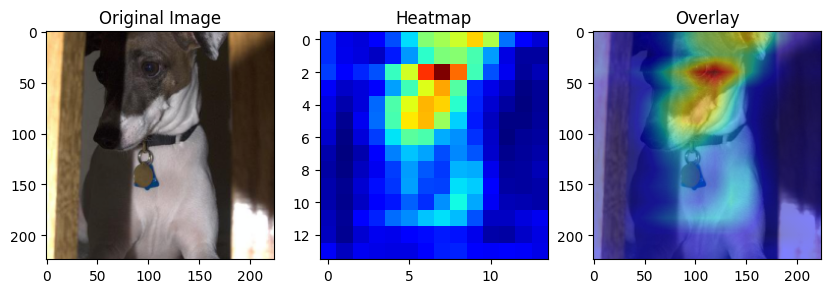

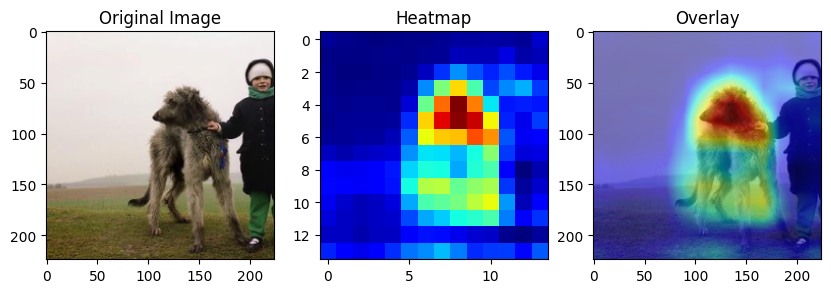

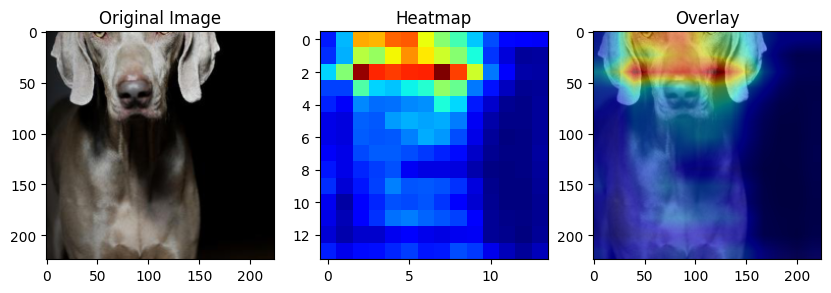

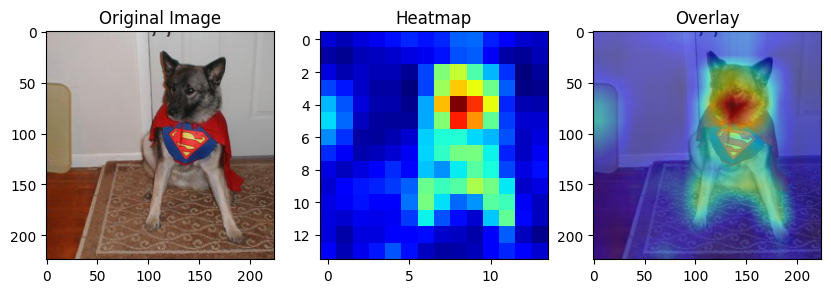

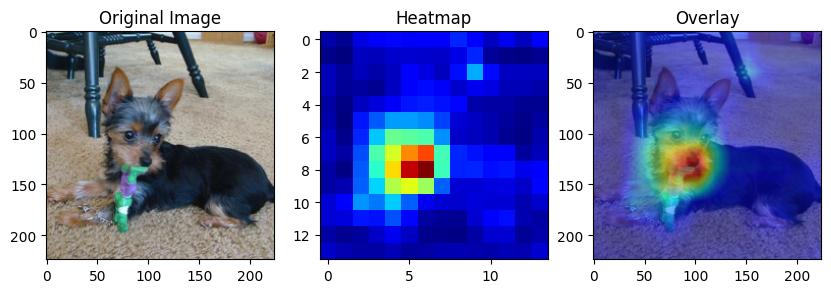

In [ ]:
model = load_model()
dataloader = load_data()
register_hook(model)
# Step 4: Get an image from the dataset
images, labels = next(iter(dataloader))

for i in range(5):  # we're doing this for 5 images
  image = images[i].unsqueeze(0)  # get the ith image from the batch
  output, predicted_class = forward_pass(model, image)
  activations = compute_gradients(model)
  heatmap = generate_heatmap(activations)
  display_images(image, heatmap)

In [ ]:
import pandas as pd
from PIL import Image
from pathlib import Path
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
with open("imagenet1000_clsidx_to_labels.txt") as f:
    class_idx_to_name = eval(f.read())

# A function to save images
def save_image(img, path):
    img = Image.fromarray((img * 255).astype(np.uint8))
    img.save(path)

# Modified display_images function
def display_images(image, heatmap, class_name, idx):
    # Prepare the paths
    original_img_path = f'/content/gdrive/MyDrive/output_images/original_{idx}.png'
    heatmap_path = f'/content/gdrive/MyDrive/output_images/heatmap_{idx}.png'

    # Process the image for saving
    img = image.cpu().numpy()
    if img.ndim == 3:
        img = np.expand_dims(img, axis=0)
    img = img.transpose((0, 2, 3, 1))
    img = img[0]
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = img.clip(0, 1)

    # Save the original image and heatmap
    save_image(img, original_img_path)
    save_image(heatmap, heatmap_path)

    # Return the paths and class name for CSV recording
    return original_img_path, heatmap_path, class_name

In [ ]:
csv_data = pd.DataFrame(columns=['predicted_class', 'path_to_file', 'path_to_heatmap'])
Path('/content/gdrive/MyDrive/output_images').mkdir(parents=True, exist_ok=True)
model = load_model()
dataloader = load_data()
register_hook(model)

for idx, (images, labels) in enumerate(dataloader):
  if idx >= 1000:  # stop after 100 images
    break

  for i in range(images.shape[0]):
    image = images[i].unsqueeze(0)
    output, predicted_class = forward_pass(model, image)
    activations = compute_gradients(model)
    heatmap = generate_heatmap(activations)
    class_name = class_idx_to_name[predicted_class.item()]
    original_img_path, heatmap_path, class_name = display_images(image, heatmap, class_name, i+idx*images.shape[0])

    # Add the paths and class to the dataframe
    new_row = pd.DataFrame([{'predicted_class': class_name,
                         'path_to_file': original_img_path,
                         'path_to_heatmap': heatmap_path}])
    csv_data = pd.concat([csv_data, new_row], ignore_index=True)

    # Save the dataframe to a CSV file
  csv_data.to_csv('/content/gdrive/MyDrive/output.csv', index=False)

In [ ]:
!du -sh /content/gdrive/MyDrive/output_images

416M	/content/gdrive/MyDrive/output_images
